In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx


Merging adjacency table with a csv of 2022 trips: Pickup Location, Dropoff Location, and number of trips overall.

In [2]:
adjacencytable_transformed = pd.read_csv(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\adjacency_csv.csv")

In [3]:
df2022 = pd.read_csv(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\rideshares2022DOLocationIDxPULocationID.csv")

In [4]:
merged_df = pd.merge(df2022, adjacencytable_transformed, left_on=['PULocationID','DOLocationID'], right_on=['LocID', 'Adjacent_District'])
merged_df

,DOLocationID,PULocationID,trips,LocID,Adjacent_District
0,2,30,7,30.0,2
1,2,132,18,132.0,2
2,3,32,23000,32.0,3
3,3,51,30175,51.0,3
4,3,81,24298,81.0,3
...,...,...,...,...,...
1314,263,75,38693,75.0,263
1315,263,140,33708,140.0,263
1316,263,141,36169,141.0,263
1317,263,236,32364,236.0,263


In [5]:
merged_df = merged_df.drop(['LocID','Adjacent_District'], axis =1)

In [6]:
merged_df.loc[merged_df['PULocationID']==260]
#[7, 83, 129, 157, 207, 226] -- just checking to make sure the right districts were filtered.
#It works!

,DOLocationID,PULocationID,trips
28,7,260,72538
413,83,260,38705
643,129,260,68886
779,157,260,38000
1032,207,260,5248
1127,226,260,65752


Turning my merged 2022 data frame into a graph

In [7]:
G = nx.DiGraph()
for _, row in merged_df.iterrows():
    G.add_edge(row['PULocationID'], row['DOLocationID'], weight=row['trips'])
#want to retry this while maximizing for dollars spent

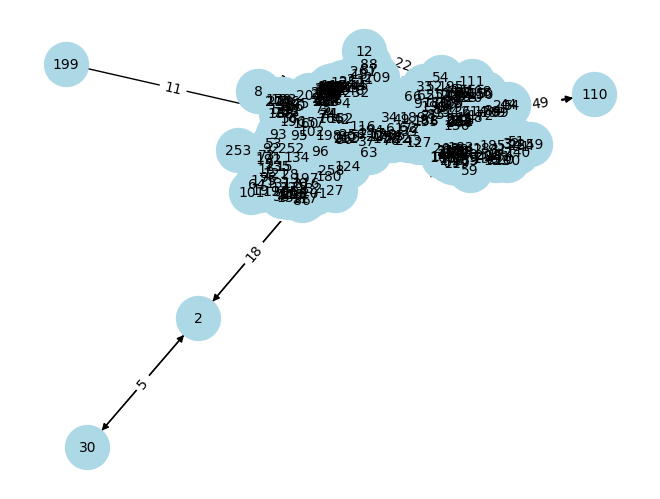

In [8]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


Weights: since a bus goes from point A to point B and point A to Point C, etc. weighting needs to be done on every possible combination as long as each zones precedes the other. Therefore, I am creating a dictionary of potential weights.

In [9]:
#this needs to be on the original dataframe
result_dict = {}

for loc, adj_loc, dist in zip(df2022['DOLocationID'], df2022['PULocationID'], df2022['trips']):
    key = (loc, adj_loc)  # Combine loc and adj_loc into a tuple
    result_dict[key] = dist

result_dict

{(1, 1): 21,
 (1, 2): 1,
 (1, 3): 232,
 (1, 4): 5728,
 (1, 5): 1511,
 (1, 6): 1234,
 (1, 7): 2589,
 (1, 8): 8,
 (1, 9): 132,
 (1, 10): 572,
 (1, 11): 489,
 (1, 12): 191,
 (1, 13): 19862,
 (1, 14): 4238,
 (1, 15): 133,
 (1, 16): 216,
 (1, 17): 5354,
 (1, 18): 420,
 (1, 19): 81,
 (1, 20): 715,
 (1, 21): 736,
 (1, 22): 1121,
 (1, 23): 5703,
 (1, 24): 3138,
 (1, 25): 9712,
 (1, 26): 2667,
 (1, 27): 20,
 (1, 28): 294,
 (1, 29): 555,
 (1, 30): 4,
 (1, 31): 43,
 (1, 32): 240,
 (1, 33): 8855,
 (1, 34): 400,
 (1, 35): 342,
 (1, 36): 3040,
 (1, 37): 5580,
 (1, 38): 127,
 (1, 39): 438,
 (1, 40): 4201,
 (1, 41): 5619,
 (1, 42): 4255,
 (1, 43): 2912,
 (1, 44): 1358,
 (1, 45): 4391,
 (1, 46): 63,
 (1, 47): 265,
 (1, 48): 49810,
 (1, 49): 6359,
 (1, 50): 19804,
 (1, 51): 253,
 (1, 52): 2586,
 (1, 53): 151,
 (1, 54): 897,
 (1, 55): 647,
 (1, 56): 224,
 (1, 57): 38,
 (1, 58): 96,
 (1, 59): 8,
 (1, 60): 160,
 (1, 61): 6796,
 (1, 62): 1922,
 (1, 63): 201,
 (1, 64): 111,
 (1, 65): 8033,
 (1, 66): 4581,
 (

This is a creating a list of all paths from one place to another given a cutoff (total number of zones hit)

In [112]:
paths = []

for path in nx.all_simple_paths(G, source=223, target=179, cutoff = 11):
    paths.append(path)

In [113]:
paths_DF = pd.DataFrame({'paths':paths})

In [114]:
paths_DF

,paths
0,"[223, 7, 146, 145, 193, 179]"
1,"[223, 7, 146, 145, 233, 162, 141, 140, 202, 19..."
2,"[223, 7, 146, 145, 233, 162, 141, 229, 140, 20..."
3,"[223, 7, 146, 145, 233, 162, 141, 262, 140, 20..."
4,"[223, 7, 146, 145, 233, 162, 141, 263, 140, 20..."
...,...
11895,"[223, 207, 260, 226, 146, 145, 193, 7, 179]"
11896,"[223, 207, 260, 226, 146, 145, 193, 179]"
11897,"[223, 207, 260, 226, 146, 145, 233, 229, 140, ..."
11898,"[223, 207, 260, 226, 146, 193, 7, 179]"


Transforming paths in a list of combinations of paths which will need to be weighted.

In [115]:
result_list = []
path_combo_list = []

for path in paths_DF['paths']:
    path_combinations = []
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            path_combinations.append((path[i],path[j]))
    result_list.append(path_combinations)

# Print the result_list or perform further processing
for path_combinations in result_list:
    path_combo_list.append(path_combinations)


In [116]:
path_combo_list

[[(223, 7),
  (223, 146),
  (223, 145),
  (223, 193),
  (223, 179),
  (7, 146),
  (7, 145),
  (7, 193),
  (7, 179),
  (146, 145),
  (146, 193),
  (146, 179),
  (145, 193),
  (145, 179),
  (193, 179)],
 [(223, 7),
  (223, 146),
  (223, 145),
  (223, 233),
  (223, 162),
  (223, 141),
  (223, 140),
  (223, 202),
  (223, 193),
  (223, 179),
  (7, 146),
  (7, 145),
  (7, 233),
  (7, 162),
  (7, 141),
  (7, 140),
  (7, 202),
  (7, 193),
  (7, 179),
  (146, 145),
  (146, 233),
  (146, 162),
  (146, 141),
  (146, 140),
  (146, 202),
  (146, 193),
  (146, 179),
  (145, 233),
  (145, 162),
  (145, 141),
  (145, 140),
  (145, 202),
  (145, 193),
  (145, 179),
  (233, 162),
  (233, 141),
  (233, 140),
  (233, 202),
  (233, 193),
  (233, 179),
  (162, 141),
  (162, 140),
  (162, 202),
  (162, 193),
  (162, 179),
  (141, 140),
  (141, 202),
  (141, 193),
  (141, 179),
  (140, 202),
  (140, 193),
  (140, 179),
  (202, 193),
  (202, 179),
  (193, 179)],
 [(223, 7),
  (223, 146),
  (223, 145),
  (223, 

Giving each path a sum.

In [117]:
sums = []
for l in range(len(path_combo_list)):
    list1 = []
    for val in range(len(path_combo_list[l])):
        try:
            list1.append(result_dict[path_combo_list[l][val]])
        except KeyError:
            list1.append(0)  # Append 0 in case of key error
    sumnums = sum(list1)
    sums.append(sumnums)


In [118]:
pathdf = pd.DataFrame({'paths':paths, 'path_combo_list': path_combo_list, 'sums': sums})

In [119]:
pathdf.head()

,paths,path_combo_list,sums
0,"[223, 7, 146, 145, 193, 179]","[(223, 7), (223, 146), (223, 145), (223, 193),...",727241
1,"[223, 7, 146, 145, 233, 162, 141, 140, 202, 19...","[(223, 7), (223, 146), (223, 145), (223, 233),...",1154041
2,"[223, 7, 146, 145, 233, 162, 141, 229, 140, 20...","[(223, 7), (223, 146), (223, 145), (223, 233),...",1327030
3,"[223, 7, 146, 145, 233, 162, 141, 262, 140, 20...","[(223, 7), (223, 146), (223, 145), (223, 233),...",1261000
4,"[223, 7, 146, 145, 233, 162, 141, 263, 140, 20...","[(223, 7), (223, 146), (223, 145), (223, 233),...",1299807


In [120]:
top  = pathdf.sort_values('sums', ascending=False).head(5)
weights_column = top['paths']
toplist = weights_column.tolist()

In [121]:
for x in range(len(toplist[0])):
    print(toplist[0][x])

223
138
129
260
83
82
157
226
145
146
7
179


In [122]:
longestpath = pd.DataFrame({'Order': range(len(toplist[0])), 'Zones': toplist[0]})
longestpath.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\longest_path_223_to_179.csv', index=False)

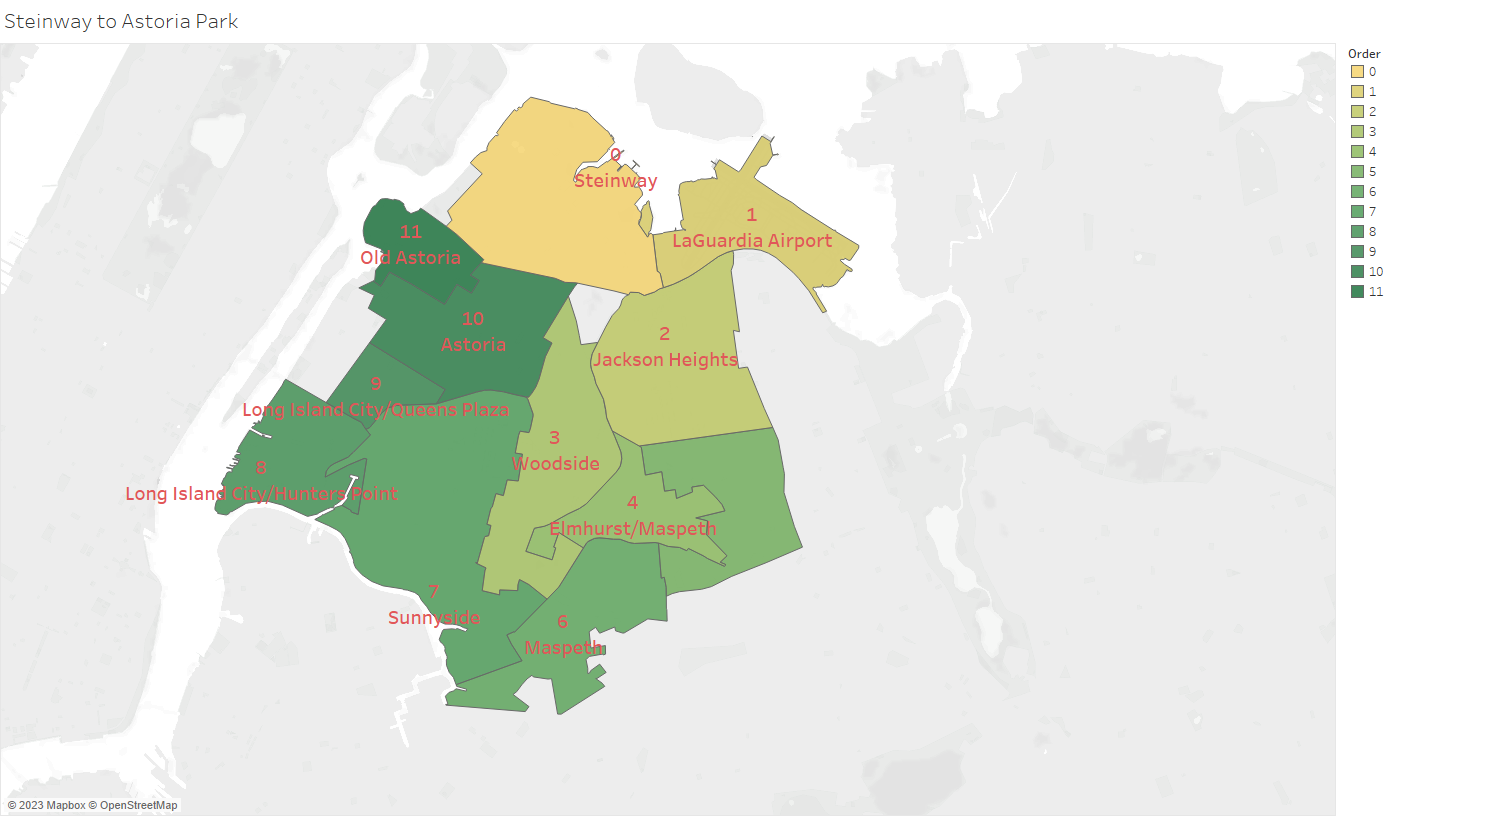

In [123]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Astoria_Circulator_Most_trafficked.png"
Image(filename=image_path)


In [130]:
paths = []

for path in nx.all_simple_paths(G, source=108, target=39, cutoff = 7):
    paths.append(path)

In [131]:
result_list = []
path_combo_list = []

for path in paths_DF['paths']:
    path_combinations = []
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            path_combinations.append((path[i],path[j]))
    result_list.append(path_combinations)

# Print the result_list or perform further processing
for path_combinations in result_list:
    path_combo_list.append(path_combinations)


In [132]:
paths_DF = pd.DataFrame({'paths':paths})

In [133]:
sums = []
for l in range(len(path_combo_list)):
    list1 = []
    for val in range(len(path_combo_list[l])):
        try:
            list1.append(result_dict[path_combo_list[l][val]])
        except KeyError:
            list1.append(0)  # Append 0 in case of key error
    sumnums = sum(list1)
    sums.append(sumnums)


In [134]:
pathdf = pd.DataFrame({'paths':paths, 'path_combo_list': path_combo_list, 'sums': sums})

In [135]:
top  = pathdf.sort_values('sums', ascending=False).head(5)
weights_column = top['paths']
toplist = weights_column.tolist()

In [136]:
longestpath = pd.DataFrame({'Order': range(len(toplist[0])), 'Zones': toplist[0]})
longestpath.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\Gravesend_to_Canarsie_Most_trafficked.csv', index=False)

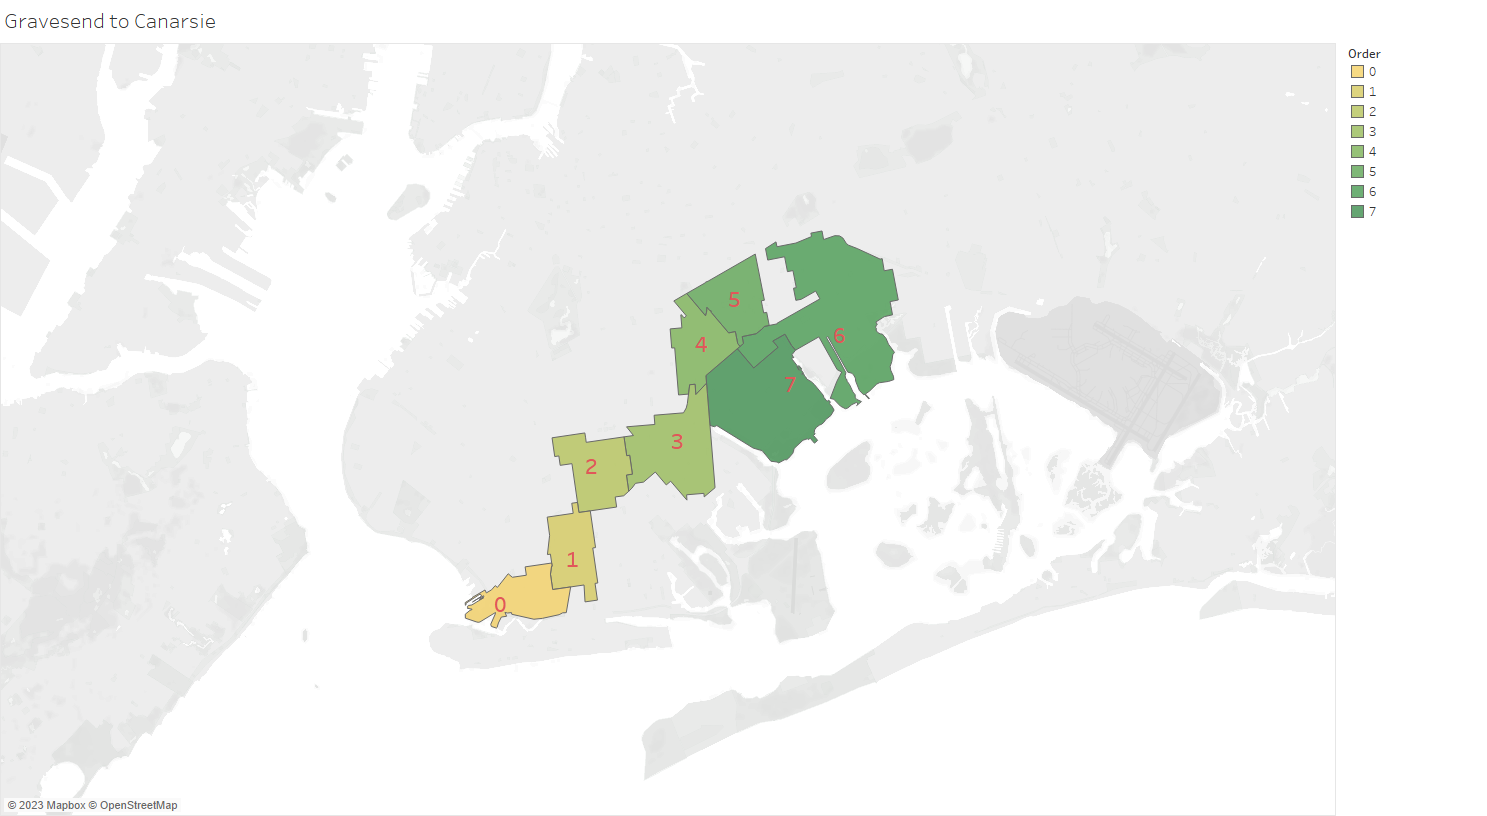

In [137]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Gravesend_to_Canarsie_Most_trafficked.png"
Image(filename=image_path)

In [139]:
paths = []
result_list = []
path_combo_list = []


for path in nx.all_simple_paths(G, source=14, target=155, cutoff = 7):
    paths.append(path)

for path in paths_DF['paths']:
    path_combinations = []
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            path_combinations.append((path[i],path[j]))
    result_list.append(path_combinations)

# Print the result_list or perform further processing
for path_combinations in result_list:
    path_combo_list.append(path_combinations)

paths_DF = pd.DataFrame({'paths':paths})

sums = []
for l in range(len(path_combo_list)):
    list1 = []
    for val in range(len(path_combo_list[l])):
        try:
            list1.append(result_dict[path_combo_list[l][val]])
        except KeyError:
            list1.append(0)  # Append 0 in case of key error
    sumnums = sum(list1)
    sums.append(sumnums)

pathdf = pd.DataFrame({'paths':paths, 'path_combo_list': path_combo_list, 'sums': sums})


In [140]:
top  = pathdf.sort_values('sums', ascending=False).head(5)
weights_column = top['paths']
toplist = weights_column.tolist()

In [141]:
longestpath = pd.DataFrame({'Order': range(len(toplist[0])), 'Zones': toplist[0]})
longestpath.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\BayRidge_to_MarinePark_Most_trafficked.csv', index=False)

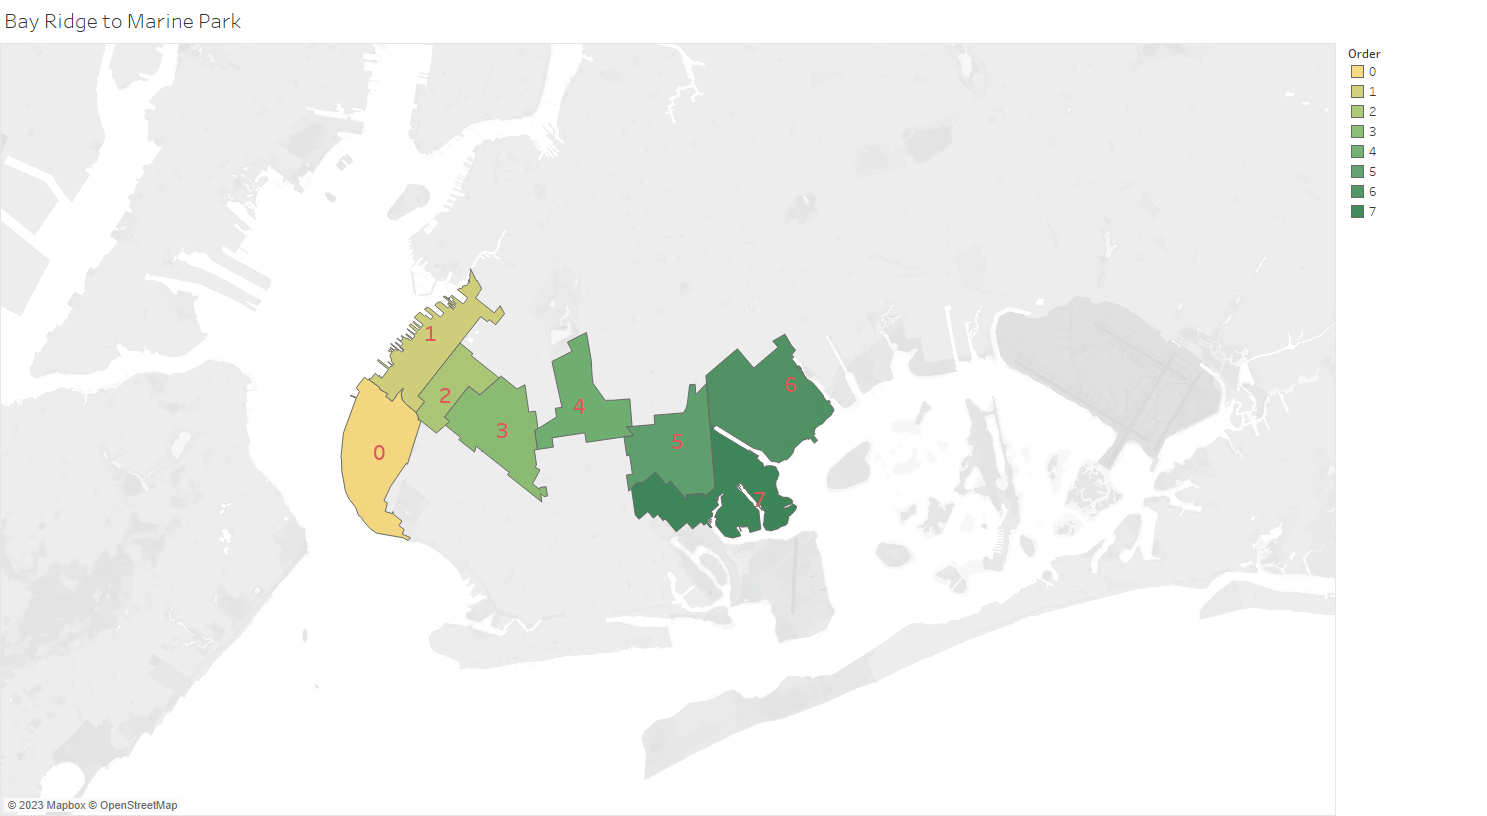

In [142]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\BayRidge_to_Marine_Park.png"
Image(filename=image_path)